This notebook is nothing spectacular, it just shows some ways of getting single and batch predictions with TensorFlow Lite.

In [37]:
from tensorflow.lite.python.interpreter import Interpreter
import pickle
import numpy as np
import time

In [15]:
birdmodel = Interpreter(model_path='../raspberrypi/model.tflite')
birdclassnames = pickle.load(open('../raspberrypi/birdclassnames.p', 'rb'))

In [113]:
bm_type = birdmodel.get_output_details()[0]['dtype']
print(f'Bird model is using the {bm_type} datatype') # quant models use uint8, others use float32 - need to adjust scripts for ints

Bird model is using the <class 'numpy.float32'> datatype


In [99]:
def get_n_random_samples(n):
    x = np.array(np.random.random_sample([n,224,224,3]), dtype=bm_type)
    return x

In [46]:
def get_n_preds(imgs):
    input_details = birdmodel.get_input_details()
    output_details = birdmodel.get_output_details()
    birdmodel.resize_tensor_input(input_details[0]['index'], (imgs.shape))
    birdmodel.resize_tensor_input(output_details[0]['index'], (imgs.shape[0], len(birdclassnames))
    birdmodel.allocate_tensors()
    birdmodel.set_tensor(input_details[0]['index'], imgs)

    birdmodel.invoke()

    return birdmodel.get_tensor(output_details[0]['index'])

In [85]:
def print_predictions(preds):
    for p in preds:
        print(birdclassnames[p.argmax(axis=0)])

# Single prediction
Testing a single prediction can be done by giving it a single tensor of size `[1,224,224,3]`

In [100]:
st = time.time()
x = get_n_random_samples(1)
preds = get_n_preds(x)
print_predictions(preds)
print(f'This took {time.time() - st} seconds!')

ekster
This took 0.05004453659057617 seconds!


# Multiple predictions
Doing multiple predictions at once is harder. I am unsure what how performance in the notebook environment translates to pi performance, but lets give it a go.

In [101]:
st = time.time()
x = get_n_random_samples(12)
preds = get_n_preds(x)
print_predictions(preds)
print(f'This took {time.time() - st} seconds!')

ekster
ekster
ekster
ekster
ekster
ekster
ekster
ekster
ekster
ekster
ekster
ekster
This took 0.3460347652435303 seconds!


# Evaluating prediction time per bird
I'm interested in the problem of scale. What if a flock flies over and I need to predict 32 birds at once? Would it be faster to predict these individually, or as a batch with resizing tensors and everything involved?

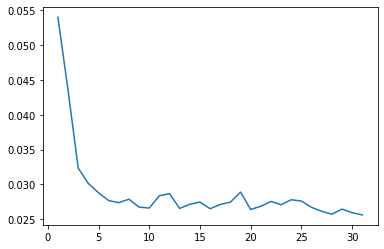

In [103]:
results = []

for i in range(1,32):
    st = time.time()
    x = get_n_random_samples(i)
    get_n_preds(x)
    results.append((time.time()-st)/np.float(i))
    
import matplotlib.pyplot as plt
plt.plot(range(1,32), results)
plt.show()

Conclusion: although the overal time for prediction goes up, the time per prediction made actually goes down the more predictions you call at once.